In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# https://github.com/ninja3697/Stocks-Price-Prediction-using-Multivariate-Analysis/blob/master/Multivatiate-LSTM/.ipynb_checkpoints/Multivariate-3-LSTM-Copy1-checkpoint.ipynb
# Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import Dropout
from sklearn.model_selection import KFold
from math import sqrt
import datetime as dt
plt.style.use('ggplot')

In [6]:
%cd '/content/drive/Shareddrives/myShareDrive'

/content/drive/Shareddrives/myShareDrive


In [7]:
#data = pd.read_csv('./dataset/FS_sp500_Value.csv', parse_dates=['Date'], infer_datetime_format=True)
data = pd.read_csv('./dataset/FS_sp500_Value.csv', parse_dates=['Date'], infer_datetime_format=True, index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
#data_APA = data.query('Ticker == "APA"').drop(['Unnamed: 0', 'Ticker'], axis=1)
data_APA = data.query('Ticker == "APA"').drop(['Ticker'], axis=1)

In [9]:
# Using set_index() method on 'Name' column
data_APA = data_APA.set_index(data_APA['Date'])

In [10]:
# Correlation matrix
data_APA.corr()['Close']

High         0.999711
Low          0.999743
Open         0.999399
Close        1.000000
Volume      -0.479447
Adj Close    0.999291
Name: Close, dtype: float64

In [ ]:
#data_APA = data_APA.drop(['Volume'], axis=1)

In [ ]:
#print(data_APA.describe().Volume) 

In [11]:
data_APA.drop(data_APA[data_APA['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

In [12]:
data_APA.shape

(2997, 7)

In [13]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [14]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs,loss,activation):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, activation = activation, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))
    # Adding LSTM layers and some Dropout regularisation
    for i in range(len(hl)-1):        
      model.add(LSTM(hl[i], activation = activation,return_sequences = True))
      #model.add(Dropout(0.2))
    model.add(LSTM(hl[-1],activation = activation))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= lr), loss = loss)
    
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [15]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [16]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [17]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [18]:
# Extracting the series
series = data_APA[['Close','High','Volume']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2997, 3)
                Close       High    Volume
Date                                      
2021-11-19  26.000000  27.010000  12427500
2021-11-22  26.530001  27.360001  11652900
2021-11-23  28.469999  28.500000  10602000
2021-11-24  28.610001  29.209999   8531600
2021-11-26  26.240000  26.549999   8469000


In [19]:
# Cross_Train_Val Test Split
cross_train_val_start = dt.date(2010,1,4)
cross_train_val_end = dt.date(2021,6,30)
cross_train_val_data = series.loc[cross_train_val_start:cross_train_val_end]

test_start = dt.date(2021,7,1)
test_end = dt.date(2021,12,31)
test_data = series.loc[test_start:test_end]

print(cross_train_val_data.shape,test_data.shape)

(2893, 3) (104, 3)


In [20]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

train = sc.fit_transform(cross_train_val_data)
test = sc.transform(test_data)
print(train.shape,test.shape)

(2893, 3) (104, 3)


In [50]:
timesteps = [50] 
#hl = []
#for i in range(60,50,10):
#  hl.append([i,i-5])
hl = [[60,55]]
lr = [1e-3]
batch_size = [64]
num_epochs = [50]
#optimizers = ['SGD', 'RMSprop', 'Adam']
loss = ['mean_squared_error']
activation = ['selu']

Epoch 1/50
36/36 [==============================] - 24s 472ms/step - loss: 0.0354 - val_loss: 0.2833
Epoch 2/50
36/36 [==============================] - 17s 460ms/step - loss: 0.0243 - val_loss: 0.3718
Epoch 3/50
36/36 [==============================] - 16s 458ms/step - loss: 0.0211 - val_loss: 0.0563
Epoch 4/50
36/36 [==============================] - 17s 460ms/step - loss: 0.0073 - val_loss: 0.1114
Epoch 5/50
36/36 [==============================] - 17s 460ms/step - loss: 0.0101 - val_loss: 0.1226
Epoch 6/50
36/36 [==============================] - 17s 461ms/step - loss: 0.0114 - val_loss: 0.0906
Epoch 7/50
36/36 [==============================] - 17s 460ms/step - loss: 0.0094 - val_loss: 0.0586
Epoch 8/50
36/36 [==============================] - 17s 460ms/step - loss: 0.0067 - val_loss: 0.0524
Epoch 9/50
36/36 [==============================] - 16s 458ms/step - loss: 0.0057 - val_loss: 0.0468
Epoch 10/50
36/36 [==============================] - 17s 462ms/step - loss: 0.0050 - val_lo

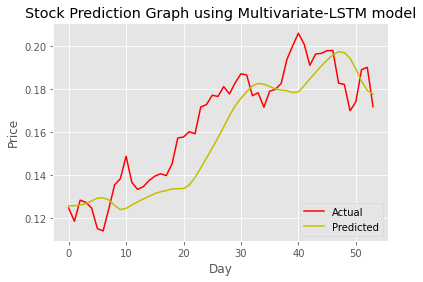

train_error  [0.03544359654188156, 0.0242941714823246, 0.02106187492609024, 0.007264916319400072, 0.01006848644465208, 0.011423538438975811, 0.009355121292173862, 0.006676614750176668, 0.00572043564170599, 0.004998829215764999, 0.004622022621333599, 0.005404209718108177, 0.00563512509688735, 0.005591400433331728, 0.006127835717052221, 0.004757008980959654, 0.006623147986829281, 0.0060733892023563385, 0.006322037428617477, 0.0043888702057302, 0.005425058305263519, 0.004872565623372793, 0.006221561226993799, 0.004363528452813625, 0.005232651252299547, 0.003594830632209778, 0.0032996307127177715, 0.0026484711561352015, 0.002365686697885394, 0.0015404816949740052, 0.0017168932827189565, 0.0013610825408250093, 0.0014476635260507464, 0.0012218272313475609, 0.0012283084215596318, 0.0011688345111906528, 0.001172326970845461, 0.001221882994286716, 0.0011998619884252548, 0.001452900585718453, 0.0011732239509001374, 0.0015945677878335118, 0.0012744783889502287, 0.0013602051185443997, 0.0013399975

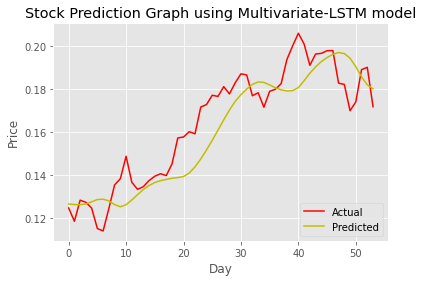

train_error  [0.051913246512413025, 0.01654711179435253, 0.039937250316143036, 0.039265722036361694, 0.03206568583846092, 0.017016980797052383, 0.015564252622425556, 0.011703615076839924, 0.01250943262130022, 0.010027192533016205, 0.007551597431302071, 0.004816236440092325, 0.00345870153978467, 0.002514592371881008, 0.0024927991908043623, 0.0023870232980698347, 0.0029628898482769728, 0.0025279908441007137, 0.0027733745519071817, 0.0027637870516628027, 0.003990447148680687, 0.0035824168007820845, 0.004756037145853043, 0.004272813908755779, 0.005200781859457493, 0.00501289963722229, 0.0048231990076601505, 0.004521515220403671, 0.00469078216701746, 0.00438713887706399, 0.004287448246032, 0.0038237622939050198, 0.0046394383534789085, 0.00307878153398633, 0.00418086489662528, 0.0036521581932902336, 0.002789393998682499, 0.003124012378975749, 0.002875795355066657, 0.0028592071030288935, 0.002469823695719242, 0.003140965010970831, 0.0022907385136932135, 0.0026309043169021606, 0.00241755694150

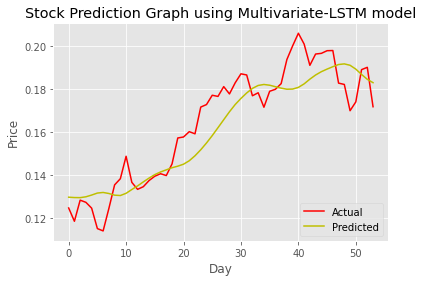

train_error  [0.07650518417358398, 0.024863669648766518, 0.034027550369501114, 0.017807476222515106, 0.011799083091318607, 0.010369250550866127, 0.008504056371748447, 0.005619108211249113, 0.005030899308621883, 0.0039719450287520885, 0.0034445468336343765, 0.003265839070081711, 0.0033498993143439293, 0.0030621252954006195, 0.003099334193393588, 0.00287168868817389, 0.0033734964672476053, 0.0026399961207062006, 0.0025643815752118826, 0.0027673651929944754, 0.0026087735313922167, 0.0026283154729753733, 0.0026615276001393795, 0.002586791990324855, 0.002834124956279993, 0.00284795043990016, 0.0026209817733615637, 0.002519058296456933, 0.002693473594263196, 0.0026674678083509207, 0.002908578608185053, 0.003548775566741824, 0.0034747710451483727, 0.003121446818113327, 0.002718630013987422, 0.00249109067954123, 0.0023463869001716375, 0.002779746428132057, 0.0024766246788203716, 0.002546042902395129, 0.0022151502780616283, 0.0021897524129599333, 0.001991735538467765, 0.002146939281374216, 0.00

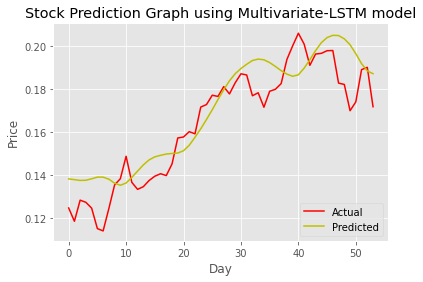

train_error  [0.03219829499721527, 0.03441977500915527, 0.031708624213933945, 0.02575462870299816, 0.015595476143062115, 0.013028349727392197, 0.010670692659914494, 0.009061545133590698, 0.009600532241165638, 0.009635563008487225, 0.00872497633099556, 0.007720624096691608, 0.008616351522505283, 0.007904920727014542, 0.007083800155669451, 0.006486664991825819, 0.005398792214691639, 0.005610333289951086, 0.006189380772411823, 0.0048399558290839195, 0.004885335918515921, 0.004298653919249773, 0.004067185800522566, 0.003617001697421074, 0.003529382636770606, 0.0027195254806429148, 0.003307354636490345, 0.0027216454036533833, 0.002962014637887478, 0.0026131009217351675, 0.0027795617934316397, 0.002951320493593812, 0.002425007987767458, 0.002557266503572464, 0.0022885382641106844, 0.0022612684406340122, 0.0022931648418307304, 0.0024099310394376516, 0.0021860466804355383, 0.0023506239522248507, 0.0021653196308761835, 0.002515956526622176, 0.002214201260358095, 0.002232546918094158, 0.00239317

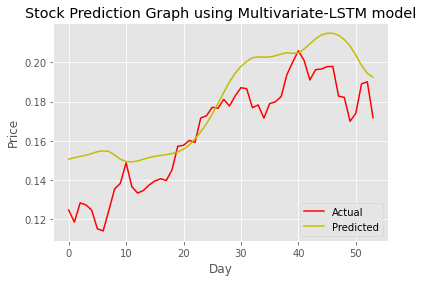

train_error  [0.08980995416641235, 0.027438286691904068, 0.019524963572621346, 0.014902910217642784, 0.010505445301532745, 0.012180903926491737, 0.010628575459122658, 0.007973389700055122, 0.006444874685257673, 0.005894453264772892, 0.005053474102169275, 0.0051275864243507385, 0.005051253363490105, 0.004547820892184973, 0.0040717520751059055, 0.003973080310970545, 0.00358444987796247, 0.003351561026647687, 0.0037194080650806427, 0.0034958620090037584, 0.004028764553368092, 0.004010077565908432, 0.0037905897479504347, 0.003967683762311935, 0.004617779515683651, 0.004576091654598713, 0.0048231626860797405, 0.005015979055315256, 0.004694731906056404, 0.004220101051032543, 0.004518668167293072, 0.004057721234858036, 0.003458956256508827, 0.0030736136250197887, 0.002847585827112198, 0.0026689772494137287, 0.002349800430238247, 0.002392576774582267, 0.0023105056025087833, 0.002294467529281974, 0.0023167806211858988, 0.0025432477705180645, 0.002344343811273575, 0.002144951606169343, 0.0023576

In [51]:
results = list()
cross_val_results = list()
n_split = 5
X = train

for t in timesteps:
  for l in hl:
      for rate in lr:
          for batch in batch_size:
              for epochs in num_epochs:
                for loss in loss:
                  for a in activation:
                    
                    train_loss = pd.DataFrame()
                    val_loss = pd.DataFrame()
                    train_loss_value = 0
                    val_loss_value = 0
                
                    for train_index,test_index in KFold(n_split).split(X):
                      #print(train_index,test_index)
                      x_train = X[train_index]
                      x_test = X[test_index]
                      #y_train,y_test=Y[train_index],Y[test_index]
                      model,train_error,val_error = fit_model(x_train,x_test,t,l,rate,batch,epochs,loss,a)
                      train_loss['fold'] = train_error
                      val_loss['fold'] = val_error
                      mse, rmse, r2_value,true,predicted = evaluate_model(model,test,t)
                      #print("Split 1", fold_no)
                      print('MSE = {}'.format(mse))
                      print('RMSE = {}'.format(rmse))
                      print('R-Squared Score = {}'.format(r2_value))
                      
                      plot_data(true,predicted)
                      cross_val_results.append([mse,rmse,r2_value,0])
                      #model,train_error,val_error = fit_model(x_train,x_test,timesteps,hl,lr,batch_size,num_epochs)
                      print('train_error ',train_error)
                      #model,train_loss,val_loss = fit_model(train,val,t,l,rate,batch,epochs)
                      train_loss_value = train_loss_value + train_loss.iloc[-1]['fold']
                      val_loss_value = val_loss_value + val_loss.iloc[-1]['fold']
                
                    results.append([t,l,rate,batch,epochs,loss,a,train_loss_value/n_split,val_loss_value/n_split])
                    print(results)                  

pd.DataFrame(results,columns=['Timestep','Hidden_Layers','Learning_Rate','Batch_Size','epochs','Loss','Activation','Train_Loss','Val_Loss']).to_csv('Multivariate-LSTM_model_Timesteps_0107.csv')
pd.DataFrame(cross_val_results,columns=['mse','rmse','r2_value','0']).to_csv('Multivariate-LSTM_model_Mse_0107.csv')

In [52]:
results

[[50,
  [60, 55],
  0.001,
  64,
  50,
  'mean_squared_error',
  'selu',
  0.002537284139543772,
  0.006073606034624391]]

In [53]:
cross_val_results

[[0.00020090073183243656, 0.014173945528060864, 0.7116805830718771, 0],
 [0.00015148051610536556, 0.012307742120525827, 0.7826052016779235, 0],
 [0.00012619298847348404, 0.011233565261015046, 0.818896185567713, 0],
 [0.00015321995740338743, 0.012378204934617436, 0.7801088707972343, 0],
 [0.0003828455047045852, 0.019566438222236186, 0.45056550225987213, 0]]

In [64]:
# Data (train,val,test data) for Building model
train_start = dt.date(2010,1,4)
train_end = dt.date(2019,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2020,1,1)
val_end = dt.date(2021,6,30)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2021,7,1)
test_end = dt.date(2021,11,26)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(2516, 3) (377, 3) (104, 3)


In [65]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

train = sc.fit_transform(train_data)
val = sc.fit_transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2516, 3) (377, 3) (104, 3)


In [66]:
# Parameters
timesteps = 50
hl = [60,55]
lr = 1e-3
batch = 64
epochs = 100
#optimizers = ['Adam']
loss = 'mean_squared_error'
activation = 'selu'

In [67]:
X_train = []
Y_train = []
X_val = []
Y_val = []
  
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)
  
# Loop for val data
for i in range(timesteps,val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)
    
# Adding Layers to the model
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation = activation, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
# Adding LSTM layers and some Dropout regularisation
for i in range(len(hl)-1):        
  model.add(LSTM(hl[i], activation = activation,return_sequences = True))
  #model.add(Dropout(0.2))
model.add(LSTM(hl[-1],activation = activation))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= lr), loss = loss)
    
# Training the data
history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
model.reset_states()
#model, history.history['loss'], history.history['val_loss']

Epoch 1/100
39/39 [==============================] - 24s 482ms/step - loss: 0.0284 - val_loss: 0.0103
Epoch 2/100
39/39 [==============================] - 18s 472ms/step - loss: 0.0098 - val_loss: 0.0163
Epoch 3/100
39/39 [==============================] - 18s 466ms/step - loss: 0.0159 - val_loss: 0.0102
Epoch 4/100
39/39 [==============================] - 18s 465ms/step - loss: 0.0147 - val_loss: 0.0114
Epoch 5/100
39/39 [==============================] - 18s 470ms/step - loss: 0.0123 - val_loss: 0.0076
Epoch 6/100
39/39 [==============================] - 18s 464ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 7/100
39/39 [==============================] - 18s 462ms/step - loss: 0.0091 - val_loss: 0.0045
Epoch 8/100
39/39 [==============================] - 18s 467ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 9/100
39/39 [==============================] - 18s 464ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 10/100
39/39 [==============================] - 18s 470ms/step - loss: 0.004

MSE = 0.0014981071162395126
RMSE = 0.03870538872352935
R-Squared Score = 0.8876417258075385


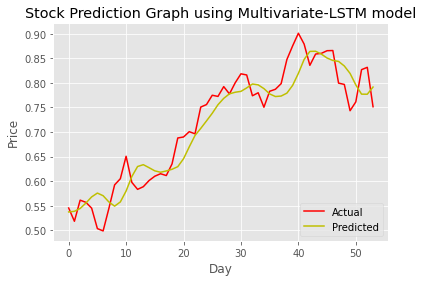

In [68]:
results = list()
cross_val_results = list()

mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)

print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
                      
plot_data(true,predicted)


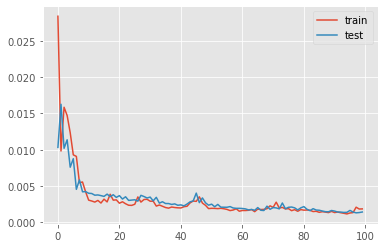

In [69]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [70]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50, 50)            10800     
                                                                 
 dropout_12 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 50, 60)            26640     
                                                                 
 lstm_20 (LSTM)              (None, 55)                25520     
                                                                 
 dropout_13 (Dropout)        (None, 55)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 56        
                                                                 
Total params: 63,016
Trainable params: 63,016
Non-trai

In [71]:
print(history.history['loss'])

[0.028415268287062645, 0.009822038002312183, 0.015857525169849396, 0.014721237123012543, 0.012334727682173252, 0.009292937815189362, 0.009077480994164944, 0.005449837073683739, 0.005544764455407858, 0.004197289235889912, 0.0030416271183639765, 0.002921321662142873, 0.0027752493042498827, 0.0030023183207958937, 0.002641631755977869, 0.00317767565138638, 0.0027969982475042343, 0.003852288005873561, 0.0030407682061195374, 0.003079264424741268, 0.0026172492653131485, 0.00281531666405499, 0.002545091323554516, 0.0023382948711514473, 0.0023179538547992706, 0.0024746176786720753, 0.0034817561972886324, 0.0027730048168450594, 0.003127530450001359, 0.0031598403584212065, 0.002894788281992078, 0.0028970292769372463, 0.0022232811897993088, 0.0023708981461822987, 0.002198403002694249, 0.0020228740759193897, 0.0019364662002772093, 0.002092045499011874, 0.0020238826982676983, 0.001980825560167432, 0.001963709481060505, 0.0021364481654018164, 0.0021950695663690567, 0.0026663863100111485, 0.0029209458

In [72]:
print(history.history['val_loss'])

[0.010317390784621239, 0.016270233318209648, 0.010195312090218067, 0.011370114982128143, 0.007586444728076458, 0.00875844806432724, 0.004531411454081535, 0.005834460258483887, 0.004194081295281649, 0.0042202528566122055, 0.003990876022726297, 0.0039558252319693565, 0.003724012989550829, 0.003759960411116481, 0.0036649322137236595, 0.0035577614326030016, 0.0038716071285307407, 0.0035244054161012173, 0.0037885510828346014, 0.0034223704133182764, 0.0036646754015237093, 0.003192585427314043, 0.0035067943390458822, 0.003005252918228507, 0.0030489310156553984, 0.003095522290095687, 0.0029027096461504698, 0.0037054847925901413, 0.0035405289381742477, 0.003339244984090328, 0.0034624706022441387, 0.0029433288145810366, 0.003431208897382021, 0.002628678921610117, 0.0028208207804709673, 0.0025747818872332573, 0.0025723143480718136, 0.002450404455885291, 0.0025237451773136854, 0.0023348082322627306, 0.0023888072464615107, 0.002250113058835268, 0.00250192335806787, 0.0028090111445635557, 0.00293408

In [73]:
model.save('DL_Project_LSTM_20220110')

INFO:tensorflow:Assets written to: DL_Project_LSTM_20220110/assets


INFO:tensorflow:Assets written to: DL_Project_LSTM_20220110/assets
